In [1]:
#Load in Packages
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib.patches as patches
import cartopy.feature as cfeature

ERROR 1: PROJ: proj_create_from_database: Open of /home/k16v981/.conda/envs/my_env/share/proj failed


# Indian Ocean Dipole
### and its relationship with the Southern African Rainfall in the Austral Summer

In [2]:
mon_sst_anom = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_sst_month_anom.nc')
mon_sst_anom =  mon_sst_anom.sortby('valid_time')

mon_sst_anom = mon_sst_anom.rename({'valid_time': 'date'})

new_dates = pd.to_datetime(mon_sst_anom.coords['date']).to_period('M').start_time
mon_sst_anom = mon_sst_anom.assign_coords(date=new_dates)

### The Indian Ocean Dipole is the difference of the Temperature of the Western Region (off the coast of the Horn of Africa) and the Eastern Region off the Coast of Sumatra

In [7]:
#Create the West and East Regions
west_region_iod = mon_sst_anom['sst'].sel(
    longitude=slice(50, 70),  # Longitude range
    latitude=slice(10, -10)        # Latitude range
)

east_region_iod = mon_sst_anom['sst'].sel(
    longitude=slice(90, 110),  # Longitude range
    latitude=slice(10, -10)        # Latitude range
)

west_region_iod = west_region_iod.mean(dim=('latitude', 'longitude'))
east_region_iod = east_region_iod.mean(dim=('latitude', 'longitude'))

iod_index = west_region_iod - east_region_iod

### Let's see what the Dipole looks like over time

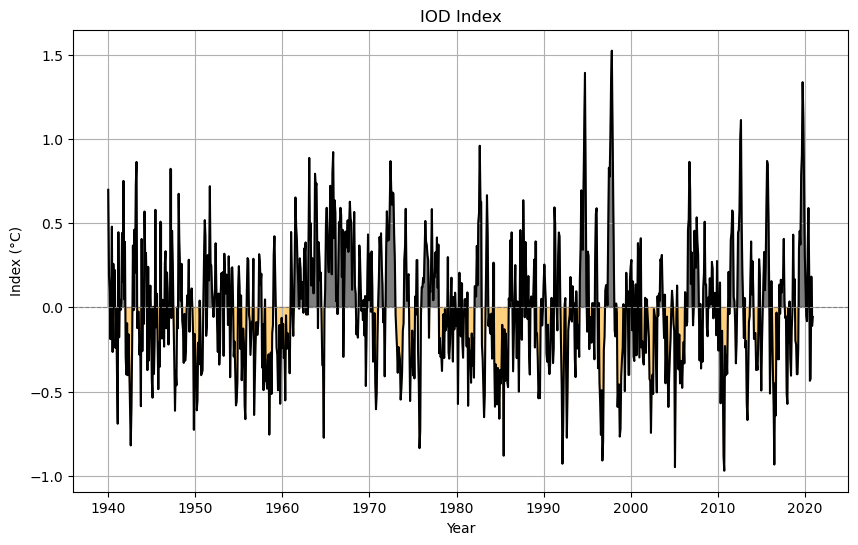

In [8]:
#Create a plot of the IOD Index from 1940-2020
plt.figure(figsize=(10, 6))

# Plot the 
plt.plot(iod_index['date'], iod_index, color='black')

# Fill areas above and below zero
plt.fill_between(iod_index['date'], iod_index, 0, where=(iod_index > 0), color='black', alpha=0.5)
plt.fill_between(iod_index['date'], iod_index, 0, where=(iod_index < 0), color='orange', alpha=0.5)

# Add labels and title
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--')  # Add a horizontal line at y=0
plt.title('IOD Index')
plt.xlabel('Year')
plt.ylabel('Index (°C)')
plt.grid()

# Show the plot
plt.show()

In [3]:
# Let's take the whole region so we can visualize it
whole_region_iod = mon_sst_anom['sst'].sel(
    longitude=slice(40, 115),  # Longitude range
    latitude=slice(15, -15)        # Latitude range
)
print(whole_region_iod)

<xarray.DataArray 'sst' (date: 972, latitude: 121, longitude: 301)> Size: 142MB
[35401212 values with dtype=float32]
Coordinates:
    number     (date) int64 8kB ...
  * latitude   (latitude) float64 968B 15.0 14.75 14.5 ... -14.5 -14.75 -15.0
  * longitude  (longitude) float64 2kB 40.0 40.25 40.5 ... 114.5 114.8 115.0
    surface    (date) float64 8kB ...
    month      (date) int64 8kB ...
  * date       (date) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2020-12-01


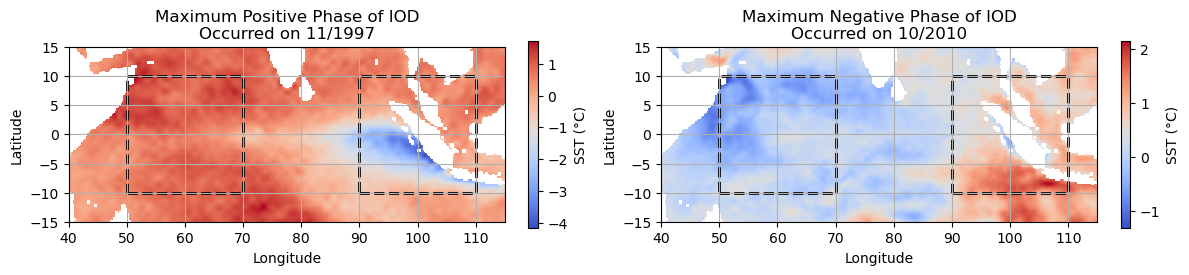

In [10]:
max_positive_idx = iod_index.argmax()
max_negative_idx = iod_index.argmin()

max_positive_time = iod_index.date[max_positive_idx]
max_negative_time = iod_index.date[max_negative_idx]

# Extract corresponding SST data
sst_positive = whole_region_iod.sel(date=max_positive_time, method = 'nearest')
sst_negative = whole_region_iod.sel(date=max_negative_time, method = 'nearest')

# Step 2: Set up the plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Extent of the Indian Ocean
lon_min, lon_max = 40, 115
lat_min, lat_max = -15, 15

# Step 3: Plot the maximum positive phase
c_positive = axs[0].imshow(sst_positive, origin='upper', cmap='coolwarm', extent=[lon_min, lon_max, lat_min, lat_max])
axs[0].set_title(f'Maximum Positive Phase of IOD\nOccurred on 11/1997')
axs[0].set_xlabel('Longitude')
axs[0].set_ylabel('Latitude')

# Draw boxes for regions
axs[0].add_patch(plt.Rectangle((50, -10), 20, 20, linewidth=2, edgecolor='black', linestyle = '--', facecolor='none', label='Western Region'))
axs[0].add_patch(plt.Rectangle((90, -10), 20, 20, linewidth=2, edgecolor='black', linestyle = '--', facecolor='none', label='Eastern Region'))

# Step 4: Plot the maximum negative phase
c_negative = axs[1].imshow(sst_negative, origin='upper', cmap='coolwarm', extent=[lon_min, lon_max, lat_min, lat_max])
axs[1].set_title(f'Maximum Negative Phase of IOD\nOccurred on 10/2010')
axs[1].set_xlabel('Longitude')
axs[1].set_ylabel('Latitude')

# Draw boxes for regions
axs[1].add_patch(plt.Rectangle((50, -10), 20, 20, linewidth=2, edgecolor='black', linestyle = '--', facecolor='none'))
axs[1].add_patch(plt.Rectangle((90, -10), 20, 20, linewidth=2, edgecolor='black', linestyle = '--', facecolor='none'))

# Add colorbars
cbar_positive = fig.colorbar(c_positive, ax=axs[0], orientation='vertical', fraction=0.02)
cbar_positive.set_label('SST (°C)')

cbar_negative = fig.colorbar(c_negative, ax=axs[1], orientation='vertical', fraction=0.02)
cbar_negative.set_label('SST (°C)')

# Add grid and borders
for ax in axs:
    ax.grid(True)
    ax.set_xlim(lon_min, lon_max)
    ax.set_ylim(lat_min, lat_max)

plt.tight_layout()

plt.savefig('/home/k16v981/my_work/figures/southern_africa/iod_phase_extremes.jpg', format='jpg')

plt.show()

In [11]:
#Bring back our Precipitation Data
mon_precip_sa = xr.open_dataset('/home/k16v981/my_work/data/era5/era5_mon_precip_sa.nc')

mon_precip_sa['date'] = pd.to_datetime(mon_precip_sa['date'].values.astype(str), format='%Y%m%d')

o_f_precip_sa = mon_precip_sa.sel(date=(mon_precip_sa['date.month'] >= 10) | (mon_precip_sa['date.month'] <= 2))

In [12]:
#Select it to wintertime
o_f_iod = iod_index.sel(date=(iod_index['date.month'] >= 10) | (iod_index['date.month'] <= 2))

### We are going to make similar correlation plots as before

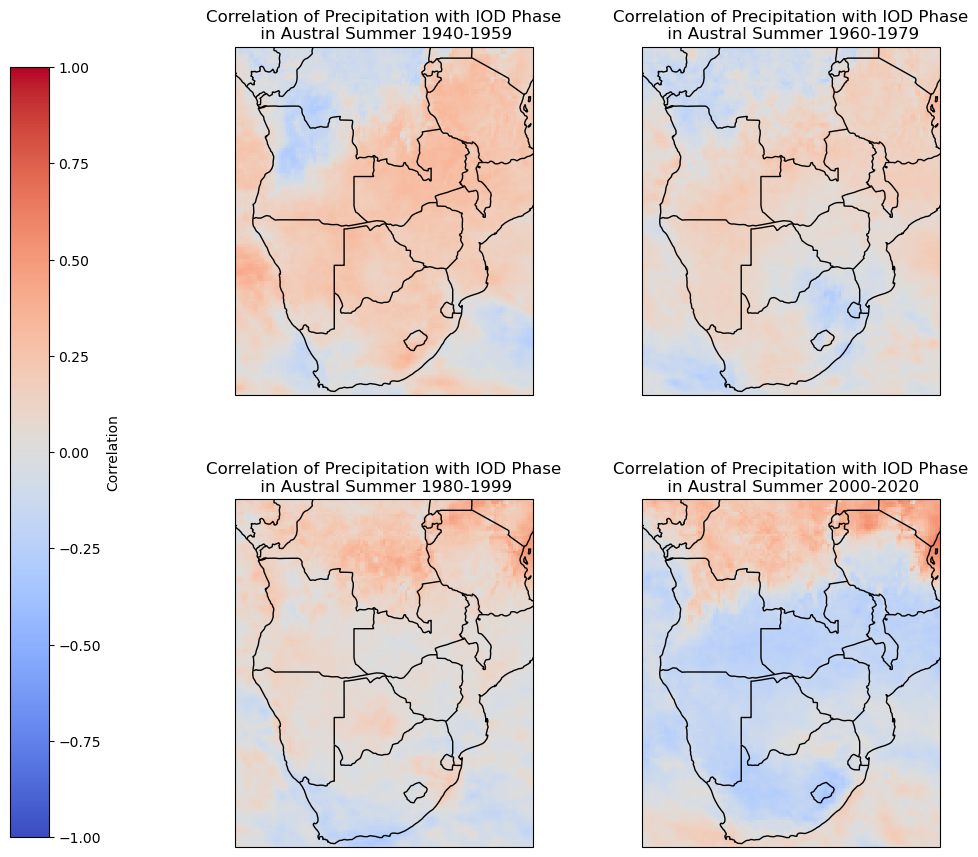

In [13]:
decades = [(1940, 1959), (1960, 1979), (1980, 1999), (2000, 2020)]
titles = ['1940-1959', '1960-1979', '1980-1999', '2000-2020']

# Create a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()  # Flatten to easily iterate over axes

# Loop over each decade
for i, (start_year, end_year) in enumerate(decades):
    # Subset data for the specific decade
    mask = (o_f_precip_sa['date'].dt.year >= start_year) & (o_f_precip_sa['date'].dt.year <= end_year)

    # Subset data for the specific decade
    o_f_precip_sa_decade = o_f_precip_sa.sel(date=mask)
    o_f_iod_decade = o_f_iod.sel(date=mask)
    
    # Calculate correlation
    correlation_decade = xr.corr(o_f_iod_decade, o_f_precip_sa_decade['tp'], dim='date')
    
    # Plot correlation
    im = correlation_decade.plot(ax=axes[i], cmap='coolwarm', vmin=-1, vmax=1, add_colorbar=False)
    axes[i].coastlines()
    axes[i].add_feature(cfeature.BORDERS)
    axes[i].set_title(f'Correlation of Precipitation with IOD Phase\n in Austral Summer {titles[i]}')

# Adjust layout
cbar = fig.colorbar(im, ax=axes, orientation='vertical', pad=.2, fraction=1)
cbar.set_label('Correlation')

plt.subplots_adjust(left=0.3, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)

plt.savefig('/home/k16v981/my_work/figures/southern_africa/corr_iod_oct_feb.jpg', format='jpg')

plt.show()